<a href="https://colab.research.google.com/github/LyreZ61/OpenCV/blob/main/mistral_finetune_own_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fine-tuning Mistral on your own data 🤙


#### Before we begin: A note on OOM errors

If you get an error like this: `OutOfMemoryError: CUDA out of memory`, tweak your parameters to make the model less computationally intensive. I will help guide you through that in this guide, and if you have any additional questions you can reach out on the [Discord channel](https://discord.gg/RN2a436M73) or on [X](https://x.com/harperscarroll).

To re-try after you tweak your parameters, open a Terminal ('Launcher' or '+' in the nav bar above -> Other -> Terminal) and run the command `nvidia-smi`. Then find the process ID `PID` under `Processes` and run the command `kill [PID]`. You will need to re-start your notebook from the beginning. (There may be a better way to do this... if so please do let me know!)

## Let's begin!
### 0. Preparing data

Before you check out a GPU, prepare your dataset for loading and training.

To prepare your dataset for loading, all you need are two `.jsonl` files structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```
If you choose to model your data as input/output pairs, you'll want to use something like the second `formatting_func` below, which will will combine all your features into one input string.

As you can see below, I have `notes.jsonl` for my `train_dataset` and `notes_validation.jsonl` for my `eval_dataset`.

I used Exporter, a free local-only app, to export my Apple Notes to `.txt` files, and then I wrote a script to process each note into one `.jsonl` file. Note that for this script, ChatGPT can help out a LOT if you tell it how your data is currently formatted, how you'd like it to be formatted, and ask it to write a script in a certain language you know well (for any debugging) to do so. I also broke up my journal entries so the training sample vector length was smaller (see the discussion on `max_length` and the data visualization below). I broke it into pieces so that contexts were encapsulated entirely, since I did want the model to understand context about my life. My data were ultimately formatted as:

```json
{"note": "journal-entry-for-model-to-predict"}
{"note": "journal-entry-for-model-to-predict-1"}
{"note": "journal-entry-for-model-to-predict-2"}
```

### 1. Load Dataset on a GPU

I used a GPU and dev environment from [brev.dev](https://brev.dev). The whole thing cost me $1 using a 1xA10G 24GB. Click the badge below to get your preconfigured instance:

[![](https://uohmivykqgnnbiouffke.supabase.co/storage/v1/object/public/landingpage/brevdeploynavy.svg)](https://console.brev.dev/environment/new?instance=A10G:g5.xlarge&diskStorage=256&name=mistral-finetune-own-data&file=https://github.com/brevdev/notebooks/raw/main/mistral-finetune-own-data.ipynb&python=3.10&cuda=12.1.1)

A single A10G (as linked) with 24GB GPU Memory was enough for me. You may need more GPUs and/or Memory if your sequence max_length is larger than 512.

Once you've checked out your machine and landed in your instance page, select the specs you'd like (I used **Python 3.10 and CUDA 12.1.1**; these should be preconfigured for you if you use the badge above) and click the "Build" button to build your verb container. Give this a few minutes.

A few minutes after your model has started Running, click the 'Notebook' button on the top right of your screen once it illuminates (you may need to refresh the screen). You will be taken to a Jupyter Lab environment, where you can upload this Notebook.


Note: You can connect your cloud credits (AWS or GCP) by clicking "Org: " on the top right, and in the panel that slides over, click "Connect AWS" or "Connect GCP" under "Connect your cloud" and follow the instructions linked to attach your credentials.

In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 14.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='df_skills_final_train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='df_skills_final_validate.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
def formatting_func(example):
    text = f"### Description: {example['input']}\n### Data: {example['output']}"
    return text

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "openchat/openchat-3.5-1210"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/11116 [00:00<?, ? examples/s]

Map:   0%|          | 0/2780 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

13896


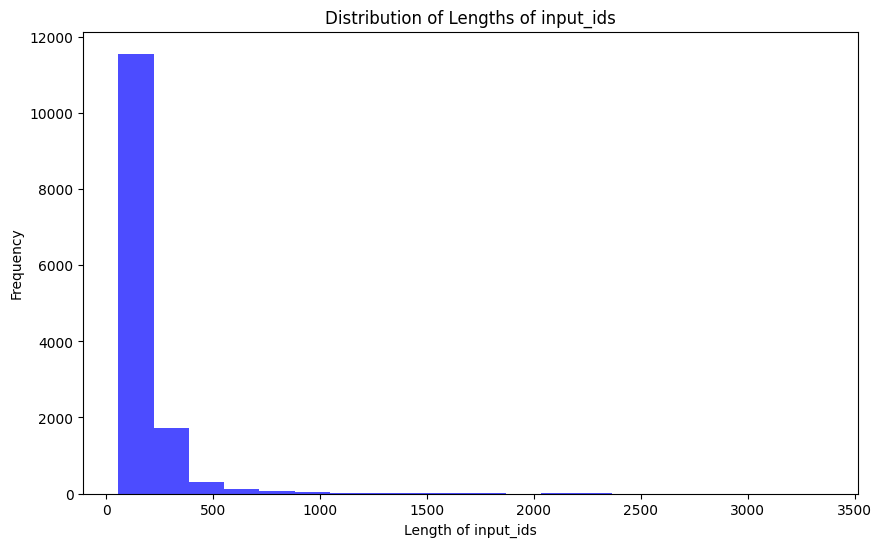

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/11116 [00:00<?, ? examples/s]

Map:   0%|          | 0/2780 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000

Now all the samples should be the same length, `max_length`.

13896


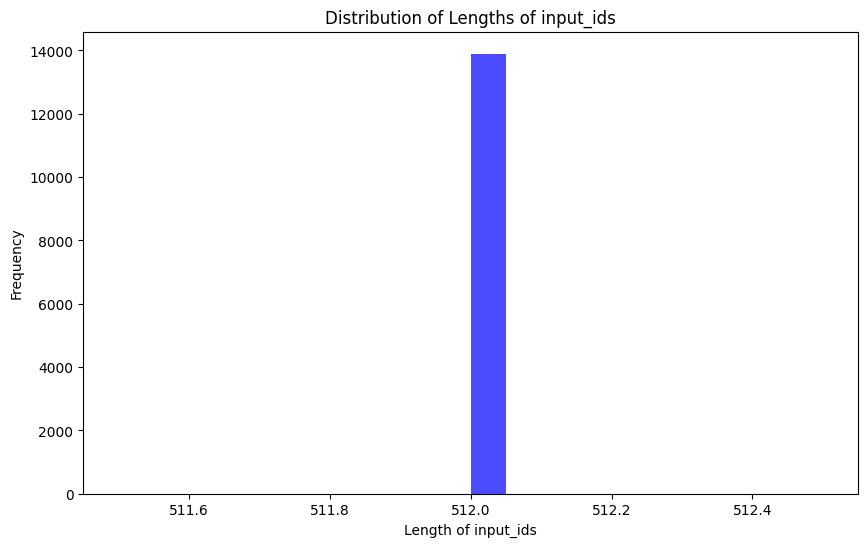

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

In [ ]:
eval_prompt = """
"Grace Hopper (919) 1231234 linkedin.com/in/gracehopper123 github.com/gracehopper123 EDUCATION The University of North Carolina at , B.S. in Computer Science GPA: 3.7/4.0 May 2025 Relevant Courses: Computer Organization, Data Structures, Foundations of Programming, Algorithms & Analysis TECHNICAL SKILLS Programming Languages: Java (Advanced), Python (Advanced), C (Intermediate), C# (Intermediate), C++ (Beginner) Operating Systems: Windows XP/Vista/7/8/10, Linux PROJECTS RESTroom Yelp Pearl Hacks Project February 2022 Collaborated with a team of 4 and developed a fully functional web application with a dynamic Javascriptbased frontend, an AJAXbased communication with a RESTful serverside API, a relational database that stores backend application state, and an ORM layer to access data in the database Designed most of the front end & debugged PHP Awarded the Most Creative Award by Appian and Best Innovation in Collaboration Award by Red Ventures Discover the New World Minigame Personal Project May 2021 Created a minigame in C# for Xbox with immersive music and sound eﬀects as well as designed the user interface using Figma Generated a random map based on a 2D array with multiple pages for the user to traverse on their west PROFESSIONAL EXPERIENCE Soware Test Engineer Intern Qualtrics , WA Summer 2022 Implemented an extensible script in Python to automate project creation with static data on tests to improve pass rates and duration, ultimately speeding up soware releases o Improved test times across 3 teams by nearly 400 with more stability Reviewed design docs and prototypes of an upcoming feature release to create nearly 50 test cases and performed manual testing and triaged 15 bugs with engineers Teaching Assistant UNC , Aug 2021 Present Mentor over 275 Introduction to Programming students, explaining challenging concepts to both Computer Science and nontechnical majors Coordinate oﬃce hours and lesson plans in conjunction with 6 other teaching assistants in order to ensure widespread availability and quickly return tests and assignments to students LEADERSHIP EXPERIENCE Director of Promotion Pearl Hacks UNC Apr 2020 Present Manage and delegate the marketing branch (directors and committee members) to establish Pearl Hack's mission to empower women and gender nonconforming beginners in tech Develop and execute the marketing strategy through social media, design, and inperson campaigns which fostered 1500+ registrations with a 60 turnout rate from representation from 30+ countries Partnered with 3 other branches and 4 other chair members to discuss how the marketing strategy plays into the function of the organization as a whole"

Based on the provided information, can you identify the skills and assess a level of each skill on a scale from 0 to 100 points?
"""

The `eval_prompt` I used was:

In [ ]:
eval_prompt = " The following is a note by CvParsing: # "

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.



"Grace Hopper (919) 1231234 linkedin.com/in/gracehopper123 github.com/gracehopper123 EDUCATION The University of North Carolina at , B.S. in Computer Science GPA: 3.7/4.0 May 2025 Relevant Courses: Computer Organization, Data Structures, Foundations of Programming, Algorithms & Analysis TECHNICAL SKILLS Programming Languages: Java (Advanced), Python (Advanced), C (Intermediate), C# (Intermediate), C++ (Beginner) Operating Systems: Windows XP/Vista/7/8/10, Linux PROJECTS RESTroom Yelp Pearl Hacks Project February 2022 Collaborated with a team of 4 and developed a fully functional web application with a dynamic Javascriptbased frontend, an AJAXbased communication with a RESTful serverside API, a relational database that stores backend application state, and an ORM layer to access data in the database Designed most of the front end & debugged PHP Awarded the Most Creative Award by Appian and Best Innovation in Collaboration Award by Red Ventures Discover the New World Minigame Personal P

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32002, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041216 || all params: 3837128768 || trainable%: 2.2162721436196535


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32002, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

### Accelerator

Set up the Accelerator. I'm not sure if we really need this for a QLoRA given its [description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp) (I have to read more about it) but it seems it can't hurt, and it's helpful to have the code for future reference. You can always comment out the accelerator if you want to try without.

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
model = accelerator.prepare_model(model)


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "openchat-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
import transformers
from datetime import datetime

project = "openchat-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=1000,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

wandb: Currently logged in as: pls2010. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.585000,1.285751
50,1.288700,1.209216
75,1.184900,1.185697
100,1.179300,1.167557
125,1.173300,1.155859
150,1.140000,1.136964
175,1.094400,1.125546
200,1.097200,1.121353
225,1.087300,1.108680
250,1.093800,1.105775


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=1000, training_loss=1.0662349758148193, metrics={'train_runtime': 9994.3143, 'train_samples_per_second': 0.2, 'train_steps_per_second': 0.1, 'total_flos': 4.4210439192576e+16, 'train_loss': 1.0662349758148193, 'epoch': 0.18})

Continue Training

In [ ]:
import transformers
from datetime import datetime

project = "cv-parsing"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

# Update max_steps to continue training
new_max_steps = 1200

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=new_max_steps,  # Updated max steps
        learning_rate=2.5e-5,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,
        logging_dir="./logs",
        save_strategy="steps",
        save_steps=25,
        evaluation_strategy="steps",
        eval_steps=25,
        do_eval=True,
        report_to="wandb",
        resume_from_checkpoint=True,
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # Re-enable for inference if needed
trainer.train()  # Continue training


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
!zip -r mistral-openchat-finetune1000.zip mistral-openchat-finetune/checkpoint-1000/

  adding: mistral-openchat-finetune/checkpoint-1000/ (stored 0%)
  adding: mistral-openchat-finetune/checkpoint-1000/optimizer.pt (deflated 17%)
  adding: mistral-openchat-finetune/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: mistral-openchat-finetune/checkpoint-1000/scheduler.pt (deflated 56%)
  adding: mistral-openchat-finetune/checkpoint-1000/adapter_model.safetensors (deflated 35%)
  adding: mistral-openchat-finetune/checkpoint-1000/adapter_config.json (deflated 53%)
  adding: mistral-openchat-finetune/checkpoint-1000/training_args.bin (deflated 51%)
  adding: mistral-openchat-finetune/checkpoint-1000/README.md (deflated 66%)
  adding: mistral-openchat-finetune/checkpoint-1000/trainer_state.json (deflated 86%)


I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`).

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "openchat/openchat-3.5-1210"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=False
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special token

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-openchat-finetune/checkpoint-300")

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [ ]:
eval_prompt =  """
'Grace Hopper (919) 1231234 linkedin.com/in/gracehopper123 github.com/gracehopper123 EDUCATION The University of North Carolina at , B.S. in Computer Science GPA: 3.7/4.0 May 2025 Relevant Courses: Computer Organization, Data Structures, Foundations of Programming, Algorithms & Analysis TECHNICAL SKILLS Programming Languages: Java (Advanced), Python (Advanced), C (Intermediate), C# (Intermediate), C++ (Beginner) Operating Systems: Windows XP/Vista/7/8/10, Linux PROJECTS RESTroom Yelp Pearl Hacks Project February 2022 Collaborated with a team of 4 and developed a fully functional web application with a dynamic Javascriptbased frontend, an AJAXbased communication with a RESTful serverside API, a relational database that stores backend application state, and an ORM layer to access data in the database Designed most of the front end & debugged PHP Awarded the Most Creative Award by Appian and Best Innovation in Collaboration Award by Red Ventures Discover the New World Minigame Personal Project May 2021 Created a minigame in C# for Xbox with immersive music and sound eﬀects as well as designed the user interface using Figma Generated a random map based on a 2D array with multiple pages for the user to traverse on their west PROFESSIONAL EXPERIENCE Soware Test Engineer Intern Qualtrics , WA Summer 2022 Implemented an extensible script in Python to automate project creation with static data on tests to improve pass rates and duration, ultimately speeding up soware releases o Improved test times across 3 teams by nearly 400 with more stability Reviewed design docs and prototypes of an upcoming feature release to create nearly 50 test cases and performed manual testing and triaged 15 bugs with engineers Teaching Assistant UNC , Aug 2021 Present Mentor over 275 Introduction to Programming students, explaining challenging concepts to both Computer Science and nontechnical majors Coordinate oﬃce hours and lesson plans in conjunction with 6 other teaching assistants in order to ensure widespread availability and quickly return tests and assignments to students LEADERSHIP EXPERIENCE Director of Promotion Pearl Hacks UNC Apr 2020 Present Manage and delegate the marketing branch (directors and committee members) to establish Pearl Hack's mission to empower women and gender nonconforming beginners in tech Develop and execute the marketing strategy through social media, design, and inperson campaigns which fostered 1500+ registrations with a 60 turnout rate from representation from 30+ countries Partnered with 3 other branches and 4 other chair members to discuss how the marketing strategy plays into the function of the organization as a whole

Based on the provided information, can you identify the skills and assess a level of each skill on a scale from 0 to 100 points?"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.



'Grace Hopper (919) 1231234 linkedin.com/in/gracehopper123 github.com/gracehopper123 EDUCATION The University of North Carolina at , B.S. in Computer Science GPA: 3.7/4.0 May 2025 Relevant Courses: Computer Organization, Data Structures, Foundations of Programming, Algorithms & Analysis TECHNICAL SKILLS Programming Languages: Java (Advanced), Python (Advanced), C (Intermediate), C# (Intermediate), C++ (Beginner) Operating Systems: Windows XP/Vista/7/8/10, Linux PROJECTS RESTroom Yelp Pearl Hacks Project February 2022 Collaborated with a team of 4 and developed a fully functional web application with a dynamic Javascriptbased frontend, an AJAXbased communication with a RESTful serverside API, a relational database that stores backend application state, and an ORM layer to access data in the database Designed most of the front end & debugged PHP Awarded the Most Creative Award by Appian and Best Innovation in Collaboration Award by Red Ventures Discover the New World Minigame Personal P

##Export to GGUF to Run Locally

1. Save Model, Tokenizer, and LoRA Checkpoint

In [ ]:
!pip install transformers torch torchvision torchaudio peft accelerate sentencepiece gguf
!pip install -U git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-xhpm3gzy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-xhpm3gzy
  Resolved https://github.com/huggingface/peft.git to commit 4186c9b104644fd247a4cc0dc2dfc1ede4665204
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
%%writefile save_model.py
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import os
import torch
import argparse

def main():

    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str)
    parser.add_argument("--lora", type=str)
    parser.add_argument("--out_dir", type=str, default="./model") # leave this
    args = parser.parse_args()

    print(f"Loading base model: {args.model}")
    base_model = AutoModelForCausalLM.from_pretrained(args.model, torch_dtype=torch.float16, device_map="auto")

    print(f"Loading PEFT: {args.lora}")
    model = PeftModel.from_pretrained(base_model, args.lora)
    print(f"Running merge_and_unload")
    model = model.merge_and_unload()
    tokenizer = AutoTokenizer.from_pretrained(args.model)

    model.save_pretrained(f"{args.out_dir}")
    tokenizer.save_pretrained(f"{args.out_dir}")
    print(f"Model saved to {args.out_dir}")

if __name__ == "__main__" :
    main()

Writing save_model.py


In [ ]:
!python save_model.py --model 'openchat/openchat-3.5-1210' --lora 'mistral-openchat-finetune/checkpoint-1000'

Loading base model: openchat/openchat-3.5-1210
Loading checkpoint shards: 100% 3/3 [00:07<00:00,  2.44s/it]
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
Loading PEFT: mistral-openchat-finetune/checkpoint-1000
Running merge_and_unload
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:557: UserWarning: The generation config instance is invalid -- `.validate()` throws warnings and/or exceptions. Fix these issues to save t

2. Convert to GGUF

In [ ]:
!curl -L -o convert.py https://github.com/ggerganov/llama.cpp/raw/master/convert.py
!curl -L -o requirements.txt https://github.com/ggerganov/llama.cpp/raw/master/requirements.txt

!pip install -r requirements.txt

# Convert the 7B model to ggml FP16 format
!python3 convert.py model

## Code below is optional - uncomment (remove leftmost '# ') to use

# # [Optional] for models using BPE tokenizers
# !python convert.py model --vocabtype bpe

# # [Optional] quantize the model to 4-bits (using q4_0 method)
!./quantize ./model/ggml-model-f16.gguf ./model/ggml-model-q4_0.gguf q4_0

# # [Optional] update the gguf filetype to current if older version is unsupported by another application
# !./quantize ./model/ggml-model-q4_0.gguf ./model/ggml-model-q4_0-v2.gguf COPY

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 51916  100 51916    0     0  64675      0 --:--:-- --:--:-- --:--:-- 64675
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   492  100   492    0     0    612      0 --:--:-- --:--:-- --:--:--  1477
ERROR: Could not open requirements file: [Errno 2] No such file or directory: './requirements/requirements-convert.txt'
Loading model file model/model-00001-of-00003.safetensors
Loading model file model/model-00001-of-00003.safetensors
Loading model file model/model-00002-of-00003.safetensors
Loading model file model/model-00003-of-00003.safetensors
params = Params(

In [ ]:
# # [Optional] quantize the model to 4-bits (using q4_0 method)
chmod +x "$PATH/NMT/get_data_enfr.sh"
sh "$PATH/NMT/get_data_enfr.sh"
!./quantize ./model/ggml-model-f16.gguf ./model/ggml-model-q4_0.gguf q4_0

SyntaxError: invalid syntax (<ipython-input-35-422ec4f4f5d4>, line 2)

In [ ]:
!zip -r openchat-model.zip model/

  adding: model/ (stored 0%)
  adding: model/model-00003-of-00003.safetensors (deflated 8%)
  adding: model/added_tokens.json (deflated 19%)
  adding: model/tokenizer_config.json (deflated 71%)
  adding: model/tokenizer.model (deflated 55%)
  adding: model/special_tokens_map.json (deflated 70%)
  adding: model/model-00001-of-00003.safetensors (deflated 9%)
  adding: model/model-00002-of-00003.safetensors (deflated 8%)
  adding: model/ggml-model-f16.gguf (deflated 8%)
  adding: model/model.safetensors.index.json (deflated 95%)
  adding: model/config.json (deflated 45%)
  adding: model/tokenizer.json (deflated 74%)


In [ ]:
import os

def get_file_size_in_gb(file_path):
    # Get file size in bytes
    size_in_bytes = os.path.getsize(file_path)

    # Convert bytes to gigabytes (1 GB = 1 billion bytes)
    size_in_gb = size_in_bytes / (1024 * 1024 * 1024)

    return size_in_gb

# Example usage
file_path = 'openchat-model.zip'  # Replace with the actual file path
size_in_gb = get_file_size_in_gb(file_path)
print(size_in_gb)


24.759789556264877
